**Общая информация**

**Срок сдачи:** 18 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import pairwise_distances

%load_ext pycodestyle_magic

In [2]:
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, 
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm = 'brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):       

        self.features = np.array(X, dtype=np.float32)
        self.target = np.array(y, dtype=np.int)
        self.classes = np.unique(self.target).size #число классов
        
        if (self.algorithm == 'kd_tree'):
            self._tree = KDTree(X, leaf_size=30)
            
        return self
    
    def matrix_distance(self, X, Y):

        x_dist = np.sum(X ** 2, axis=1).reshape(1, -1)
        y_dist = np.sum(Y ** 2, axis=1).reshape(-1, 1)
        dist = (x_dist - 2 * np.matmul(Y, X.T) + y_dist) 
        
        return dist

    def predict(self, X):
        
        result = np.zeros(X.shape[0])
        
        if (self.algorithm == 'brute'):
           
            m_distance = self.matrix_distance(self.features, X)        
            n_index = np.argpartition(m_distance, self.n_neighbors) \
            [:, :self.n_neighbors]
            n_classes = self.target[n_index]     

            for index in range(X.shape[0]):
                result[index] = Counter(n_classes[index]).most_common(1) \
                [0][0]

            return result
        
        elif (self.algorithm == 'kd_tree'):
            m_distance, n_index = self._tree.query(X, k=self.n_neighbors)
            n_classes = self.target[n_index]     

            for index in range(X.shape[0]):
                result[index] = Counter(n_classes[index]).most_common(1) \
                [0][0]

            return result
    
    def predict_proba_brute(self, X):       
        m_distance = self.matrix_distance(self.features, X)
        n_index = np.argpartition(m_distance, self.n_neighbors) \
        [:, :self.n_neighbors]
        n_classes = self.target[n_index]

        predict = np.zeros((X.shape[0], self.classes))

        for index in range(n_classes.shape[0]):
            c = Counter(n_classes[index])
            for (cls, count) in c.items():
                predict[index][cls] = count

        return predict / self.n_neighbors
        
    def predict_proba_KDTree(self, X):
        m_distance, n_index = self._tree.query(X, k=self.n_neighbors)
        n_classes = self.target[n_index] 

        predict = np.zeros((X.shape[0], self.classes))

        for index in range(n_classes.shape[0]):
            c = Counter(n_classes[index])
            for (cls, count) in c.items():
                predict[index][cls] = count

        return predict / self.n_neighbors
    
    def predict_proba(self, X):   
        if (self.algorithm == 'brute'):
            return self.predict_proba_brute(X)
        elif (self.algorithm == 'kd_tree'):
            return self.predict_proba_KDTree(X)
           
    
    def score(self, X, y):
        target = self.predict(X)
        return float((target == y).sum() / y.shape[0])

**IRIS**

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm = 'brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm = 'brute')

In [6]:
%time clf.fit(X_train, y_train)

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 4.08 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

CPU times: user 753 µs, sys: 70 µs, total: 823 µs
Wall time: 1.15 ms


MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [8]:
%time clf.predict(X_test)

CPU times: user 4.15 ms, sys: 14 µs, total: 4.17 ms
Wall time: 27.8 ms


array([1, 1, 2, 2, 1, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0])

In [9]:
%time my_clf.predict(X_test)

CPU times: user 1.62 ms, sys: 148 µs, total: 1.77 ms
Wall time: 2.28 ms


array([1., 1., 2., 2., 1., 2., 1., 0., 2., 0., 2., 0., 0., 1., 0.])

In [10]:
%time clf.predict_proba(X_test)

CPU times: user 1.76 ms, sys: 163 µs, total: 1.93 ms
Wall time: 9.55 ms


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [11]:
%time my_clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 2.47 ms, total: 2.47 ms
Wall time: 2.99 ms


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [12]:
clf.score(X_test, y_test)

1.0

In [13]:
my_clf.score(X_test, y_test)

1.0

Задание 3

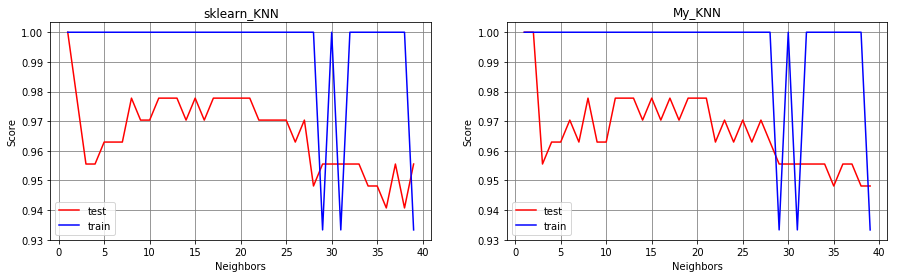

In [17]:
N = 40

train_accuracy = np.zeros(N-1)
test_accuracy = np.zeros(N-1)

sklearn_train_accuracy = np.zeros(N-1)
sklearn_test_accuracy = np.zeros(N-1)
#прогонка KNN классификатора

for ind in range(1, N):
    my_clf = MyKNeighborsClassifier(n_neighbors=ind)
    my_clf.fit(X_train, y_train)
    train_accuracy[ind-1] = my_clf.score(X_test, y_test)
    test_accuracy[ind-1] = my_clf.score(X_train, y_train)

    clf = KNeighborsClassifier(n_neighbors=ind)
    clf.fit(X_train, y_train)
    sklearn_train_accuracy[ind-1] = clf.score(X_test, y_test)
    sklearn_test_accuracy[ind-1] = clf.score(X_train, y_train)

plt.subplot(1, 2, 1)

plt.title("sklearn_KNN")
plt.plot(range(1,N), sklearn_test_accuracy, label="test", color="red")
plt.plot(range(1,N), sklearn_train_accuracy, label="train", color="blue")
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.legend()
plt.grid(color="grey")

plt.subplot(1, 2, 2)
plt.title("My_KNN")
plt.plot(range(1,N), test_accuracy, label="test", color="red")
plt.plot(range(1,N), train_accuracy, label="train", color="blue")
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.legend()
plt.grid(color="grey")

fig = plt.gcf()
fig.set_figwidth(15)
plt.show()


**MNIST**

In [18]:
mnist = fetch_mldata('MNIST original')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [20]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [21]:
%time clf.fit(X_train, y_train)

CPU times: user 2min 11s, sys: 1.08 s, total: 2min 12s
Wall time: 2min 17s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [23]:
%time my_clf.fit(X_train, y_train)

CPU times: user 90.1 ms, sys: 236 ms, total: 326 ms
Wall time: 346 ms


MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [24]:
%time clf.predict(X_test)

CPU times: user 2min 54s, sys: 156 ms, total: 2min 54s
Wall time: 3min


array([7., 5., 7., 6., 0., 0., 1., 7., 6., 3., 7., 3., 8., 3., 1., 6., 9.,
       8., 5., 4., 2., 6., 9., 9., 0., 4., 7., 8., 3., 3., 5., 2., 4., 1.,
       7., 9., 5., 4., 5., 7., 9., 5., 8., 8., 7., 1., 5., 1., 5., 7., 3.,
       4., 7., 0., 0., 1., 0., 2., 7., 8., 4., 4., 3., 5., 6., 2., 0., 4.,
       6., 0., 6., 1., 0., 3., 4., 9., 9., 3., 1., 0., 9., 0., 4., 2., 7.,
       9., 0., 6., 4., 4., 6., 2., 4., 4., 6., 7., 1., 0., 8., 1., 2., 0.,
       4., 0., 7., 7., 8., 2., 0., 1., 4., 4., 1., 3., 1., 8., 1., 1., 1.,
       0., 4., 5., 2., 7., 8., 4., 2., 3., 6., 3., 0., 0., 0., 4., 1., 9.,
       3., 3., 9., 3., 0., 3., 6., 2., 5., 6., 1., 5., 8., 8., 5., 2., 3.,
       8., 9., 7., 6., 5., 5., 3., 8., 3., 1., 9., 2., 7., 1., 4., 4., 6.,
       1., 5., 2., 4., 7., 6., 1., 6., 0., 5., 4., 1., 2., 5., 3., 6., 8.,
       4., 5., 9., 3., 2., 1., 9., 0., 2., 7., 2., 2., 8., 7., 4., 2., 8.,
       4., 5., 8., 4., 2., 7., 9., 2., 6., 7., 1., 2., 9., 2., 4., 2., 1.,
       9., 7., 0., 9., 2.

In [25]:
%time my_clf.predict(X_test)

CPU times: user 12.8 s, sys: 1.25 s, total: 14.1 s
Wall time: 10.8 s


array([7., 5., 7., 6., 0., 0., 1., 7., 6., 3., 7., 3., 8., 3., 1., 6., 9.,
       8., 5., 4., 2., 6., 9., 9., 0., 4., 7., 8., 3., 3., 5., 2., 4., 8.,
       7., 9., 5., 4., 5., 7., 9., 5., 8., 8., 7., 1., 5., 1., 5., 7., 3.,
       4., 7., 0., 0., 1., 0., 2., 7., 8., 4., 4., 3., 5., 6., 2., 0., 4.,
       6., 0., 6., 1., 0., 3., 4., 9., 9., 3., 1., 0., 9., 0., 4., 2., 7.,
       9., 0., 6., 4., 4., 6., 2., 4., 4., 6., 7., 1., 0., 8., 1., 2., 0.,
       4., 0., 7., 7., 8., 2., 0., 1., 4., 4., 1., 3., 1., 8., 1., 1., 1.,
       0., 4., 5., 2., 7., 8., 4., 2., 3., 6., 3., 0., 0., 0., 4., 1., 9.,
       3., 3., 9., 3., 0., 3., 6., 2., 5., 6., 1., 5., 8., 8., 5., 2., 3.,
       8., 9., 7., 8., 5., 5., 3., 8., 3., 1., 9., 2., 7., 1., 4., 4., 6.,
       1., 5., 2., 4., 7., 6., 1., 6., 0., 5., 4., 1., 2., 8., 5., 6., 8.,
       4., 5., 9., 3., 2., 1., 9., 0., 2., 7., 2., 2., 8., 7., 4., 2., 8.,
       4., 5., 8., 4., 2., 7., 9., 2., 6., 7., 1., 2., 9., 2., 4., 2., 1.,
       9., 7., 0., 9., 2.

In [26]:
%time clf.predict_proba(X_test)

CPU times: user 2min 55s, sys: 135 ms, total: 2min 55s
Wall time: 2min 59s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
%time my_clf.predict_proba(X_test)

CPU times: user 12.6 s, sys: 1.21 s, total: 13.8 s
Wall time: 8.64 s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
clf.score(X_test, y_test)

0.9542857142857143

In [29]:
my_clf.score(X_test, y_test)

0.9614285714285714

Задание 4

In [30]:
clf = KNeighborsClassifier(n_neighbors=4, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=4, algorithm='kd_tree')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [32]:
%time clf.fit(X_train, y_train)

CPU times: user 2min 9s, sys: 790 ms, total: 2min 9s
Wall time: 2min 12s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [33]:
%time my_clf.fit(X_train, y_train)

CPU times: user 2min 11s, sys: 2.14 s, total: 2min 13s
Wall time: 2min 15s


MyKNeighborsClassifier(algorithm='kd_tree', n_neighbors=4)

In [34]:
%time clf.predict(X_test)

CPU times: user 2min 41s, sys: 82.8 ms, total: 2min 41s
Wall time: 2min 42s


array([9., 8., 2., 8., 3., 9., 6., 9., 8., 8., 7., 2., 6., 2., 9., 4., 7.,
       8., 6., 8., 1., 6., 6., 8., 4., 3., 3., 3., 7., 5., 7., 0., 3., 1.,
       0., 7., 7., 2., 0., 0., 4., 6., 4., 5., 8., 5., 4., 2., 9., 8., 2.,
       4., 6., 0., 9., 8., 6., 8., 1., 5., 5., 1., 4., 3., 6., 7., 1., 4.,
       5., 2., 5., 3., 1., 5., 9., 6., 5., 9., 0., 3., 7., 4., 1., 0., 1.,
       6., 7., 6., 0., 4., 9., 6., 5., 6., 5., 3., 3., 9., 3., 7., 4., 2.,
       0., 2., 7., 5., 9., 8., 4., 7., 4., 1., 2., 8., 8., 1., 7., 8., 3.,
       7., 8., 1., 1., 4., 1., 3., 0., 7., 5., 0., 9., 4., 0., 1., 5., 6.,
       9., 8., 0., 9., 1., 0., 5., 7., 4., 7., 9., 9., 9., 9., 1., 5., 5.,
       9., 4., 5., 7., 8., 6., 9., 9., 7., 0., 2., 9., 2., 1., 3., 7., 3.,
       1., 6., 2., 0., 4., 0., 0., 1., 2., 2., 8., 5., 1., 6., 6., 5., 8.,
       9., 3., 7., 0., 3., 7., 2., 4., 7., 3., 0., 1., 6., 8., 9., 2., 5.,
       7., 0., 4., 2., 1., 7., 0., 7., 9., 0., 1., 3., 4., 5., 7., 8., 9.,
       9., 4., 6., 9., 9.

In [35]:
%time my_clf.predict(X_test)

CPU times: user 2min 53s, sys: 602 ms, total: 2min 53s
Wall time: 2min 59s


array([9., 8., 2., 8., 3., 9., 6., 9., 8., 8., 7., 2., 6., 2., 9., 4., 7.,
       8., 6., 8., 1., 6., 6., 8., 4., 3., 3., 3., 7., 5., 7., 0., 3., 1.,
       0., 7., 7., 2., 0., 9., 4., 6., 4., 5., 8., 5., 4., 2., 9., 8., 2.,
       4., 6., 0., 9., 8., 6., 8., 1., 5., 5., 1., 4., 3., 6., 7., 1., 4.,
       5., 2., 5., 3., 1., 5., 9., 6., 5., 9., 0., 3., 7., 4., 1., 0., 1.,
       6., 7., 6., 0., 4., 9., 6., 5., 6., 5., 3., 3., 9., 3., 7., 4., 2.,
       0., 2., 7., 5., 9., 8., 4., 7., 4., 1., 2., 8., 8., 1., 7., 8., 3.,
       7., 8., 1., 1., 4., 1., 3., 0., 7., 5., 0., 9., 4., 0., 1., 5., 6.,
       9., 8., 0., 9., 1., 0., 5., 7., 4., 9., 9., 9., 9., 9., 1., 5., 5.,
       9., 4., 5., 7., 8., 6., 9., 9., 7., 0., 2., 9., 2., 1., 3., 7., 3.,
       1., 6., 2., 0., 4., 0., 0., 1., 2., 2., 8., 5., 1., 6., 6., 5., 8.,
       9., 3., 7., 0., 3., 7., 2., 4., 7., 3., 0., 1., 6., 8., 9., 2., 5.,
       7., 0., 4., 2., 1., 7., 0., 7., 9., 0., 1., 3., 4., 5., 7., 8., 9.,
       9., 4., 6., 9., 9.

In [36]:
%time clf.predict_proba(X_test)

CPU times: user 2min 43s, sys: 89.4 ms, total: 2min 43s
Wall time: 2min 45s


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [37]:
%time my_clf.predict_proba(X_test)

CPU times: user 2min 45s, sys: 144 ms, total: 2min 45s
Wall time: 2min 47s


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [38]:
clf.score(X_test, y_test)

0.9771428571428571

In [39]:
my_clf.score(X_test, y_test)

0.9771428571428571

Задание 5

seaborn - библиотека для визуализации статистических данных основанная на matplotlib. 
Есть встроенные функции для визуализации распределения данных, линейных регрессионных моделей, временных рядов.

matplotlib - библиотека для визуализации данных, построения графиков.

train_test_split - функция, которая разделяет данные на две части: для тестирования и для тренировки. 
По умолчанию данные перед разделением перемешиваются.

Pipelin %load_exte (from sklearn.pipeline import Pipeline) - конвеер, который инкапсулирует 
последовательность преобразований данных, а затем выполняющий их последовательно.

StandardScaler (from sklearn.preprocessing import StandardScaler) - класс, который нужен, чтобы 
стандартизировать данные,(вычесть математическое ожидание и поделить на дисперсию).

ClassifierMixin - класс от которого наследуются все классификаторы в sklearn,
у него есть метод score для оценки результатов.

NeighborsBase - базовый класс KNeighbors.

KNeighborsMixin - класс, необходимый для поиска К ближайших соседей данной точки. 
kneighbors функция, которая ищет ближайших соседей возвращает расстояния и индексы.

SupervisedIntegerMixin - класс, где реализован метод fit.